In [4]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import torch

inst = 'VGNSL_split/instances_train2014.json'
coco=COCO(inst)

loading annotations into memory...
Done (t=9.42s)
creating index...
index created!


In [5]:
import urllib
from PIL import Image
from torchvision import transforms
from torchvision import models

In [201]:
# use ResNet 101
model = models.resnet101(pretrained=True)
layer = model._modules.get('fc')

for param in model.parameters():
    param.requires_grad = False
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

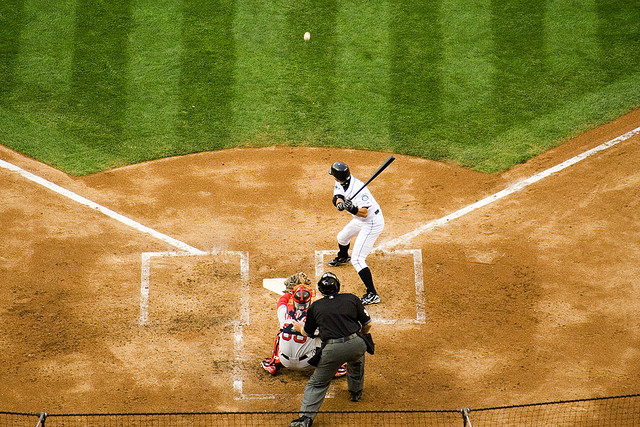

In [8]:
# get image from coco using image ids
imgIds = coco.getImgIds(imgIds = [29892])
# print(imgIds)
img = coco.loadImgs(imgIds)[0]
url = img['coco_url']
filename = img['file_name']
# download image using PIL
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename) 
input_image = Image.open(filename)
input_image

In [220]:
# preprocess image 
preprocess = transforms.Compose([
#     transforms.Resize(224), 
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
# input_tensor.shape

torch.Size([3, 336, 500])

In [216]:
input_batch = input_tensor.unsqueeze(0) # create minibatch 

# create hook
# outputs= []

# def hook(module, input, output):
#     outputs.append(output)
    
# h = layer.register_forward_hook(hook)

# if torch.cuda.is_available():
#     input_batch = input_batch.to('cuda')
#     model.to('cuda')
    
# with torch.no_grad():
#     out = model[:-1](input_batch)
# # h.remove()
# # print(outputs[0].shape)

# a = torch.squeeze(outputs[0]).numpy()


import torch.nn as nn
from torch.autograd import Variable
resnet101 = models.resnet101(pretrained=True)
modules=list(resnet101.children())[:-1]
resnet101=nn.Sequential(*modules)
# for p in resnet101.parameters():
#     p.requires_grad = False
with torch.no_grad():
    out = resnet101(input_batch)

out = torch.squeeze(out).numpy()
out
# resnet101

array([0.53083813, 0.43842837, 0.69712484, ..., 0.44581535, 0.50370485,
       0.37070677], dtype=float32)

In [132]:
vgnsl_im = np.load('VGNSL_split/dev_ims.npy')
vgnsl_img = vgnsl_im[0]
vgnsl_img

array([0.97975415, 1.6569574 , 1.7241993 , ..., 0.15878499, 1.9806446 ,
       2.1665163 ], dtype=float32)

In [121]:
a == vgnsl_img

array([False, False, False, ..., False, False, False])

In [5]:
img.keys()

dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

In [150]:
annFile = 'VGNSL_split/captions_val2014.json'
coco_caps=COCO(annFile)

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [151]:
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

A child holding a flowered umbrella and petting a yak.
A young man holding an umbrella next to a herd of cattle.
a young boy barefoot holding an umbrella touching the horn of a cow
A young boy with an umbrella who is touching the horn of a cow.
A boy holding an umbrella while standing next to livestock.
